In [1]:
import torch
from torch.utils import data
import pandas as pd
import numpy as np
from pathlib import Path 

pd.set_option('mode.chained_assignment', None)

import numpy as np
import scipy.signal as sig
import pandas as pd


def interpolate_indexes(data, idxs):
    segments = np.split(idxs, np.where(np.diff(idxs) > 1)[0] + 1)
    for seg in segments:
        if seg[0] == 0:
            data[seg[0]:seg[-1]+1] = data[seg[-1] + 1]
        elif seg[-1] == len(data) - 1:
            data[seg[0]:seg[-1]+1] = data[seg[0] - 1]
        else:
            data[seg[0]:seg[-1]+1] = np.linspace(data[seg[0] - 1], data[seg[-1] + 1], num=len(seg) + 1, endpoint=False)[1:]
    return data


def interpolate_mask(data, mask):
    idxs = np.where(mask)[0]
    return interpolate_indexes(data, idxs)


def clear_low_likelihood(data, likelihood, thresh=0.5):
    return interpolate_mask(data, likelihood < thresh)


def clear_outliers(data, hpf_freq=60, cutoff=4, fs=240):
    cutoff = fs / hpf_freq
    filt = sig.butter(4, hpf_freq, btype='high', output='ba', fs=fs)
    filtered = sig.filtfilt(*filt, data)
    return interpolate_mask(data, np.abs(filtered) > cutoff)


def smooth(data, lpf_freq=20, fs=240):
    filt = sig.butter(4, lpf_freq, btype='low', output='ba', fs=fs)
    filtered = sig.filtfilt(*filt, data)
    return filtered


def preproc(data, likelihood):
    data = clear_low_likelihood(data, likelihood)
    return smooth(clear_outliers(data))

def read_df(df_file):
    df = pd.read_hdf(df_file)
    df.columns = df.columns.droplevel(0)
    df.index.name = 'index'
    df.index = df.index.map(int)
    df = df.applymap(float)
    return df


'''
process dataframe by smoothing the x and y coordinates
'''
def process_df(df):
    body_parts = pd.unique([col[0] for col in df.columns])
    smoothed_data = {}
    for part in body_parts:
        smoothed_data[(part, 'x')] = preproc(df[part].x, df[part].likelihood)
        smoothed_data[(part, 'y')] = preproc(df[part].y, df[part].likelihood)
        smoothed_data[(part, 'likelihood')] = df[part].likelihood.copy()

    smooth_df = pd.DataFrame.from_dict(smoothed_data)
    return smooth_df


# extract and possibly normalize the coordinates to shared coordinate base - the tail-base at (0, 0), and nose on the Y axis. 
def extract_coordinates(df: pd.DataFrame, normalize: bool = True):
    N = len(df)
    xy_df = df.drop(axis=1, columns='likelihood', level=1)
    coords = xy_df.values.reshape(N, -1, 2)
    if not normalize:
        return coords
    base_tail_coords = xy_df.tailbase.values[:, np.newaxis, :]
    centered_coords = coords - base_tail_coords
    centered_nose_coords = xy_df.nose.values - xy_df.tailbase.values
    thetas = np.arctan2(centered_nose_coords[:, 1], centered_nose_coords[:, 0])
    rotation_matrices = np.stack([np.stack([np.cos(thetas), np.sin(thetas)], axis=-1),
                                  np.stack([np.sin(thetas), -np.cos(thetas)], axis=-1)], axis=-1)
    normalized_coords = np.einsum("nij,nkj->nki", rotation_matrices, centered_coords)
    return normalized_coords

def extract_coords(landmarks_file):
    df = read_df(landmarks_file)
    return pd.unique([col[0] for col in df.columns])
    
    
def process_landmarks(landmarks_file, normalize=True):
    df = read_df(landmarks_file)
    df = process_df(df)
    coords = extract_coordinates(df, normlize)
    

# A dataset of landmarks
# args: landmarks file: .h5 file of landmarks, from DeepLabCut
class LandmarkDataset(data.Dataset):
    def __init__(self, landmarks_file, normalize=True):
        super(LandmarkDataset, self).__init__()
        self.file = landmarks_file
        self.df = read_df(landmarks_file)
        self.df = process_df(self.df)
        self.coords = extract_coordinates(self.df, normalize)
        self.body_parts = pd.unique([col[0] for col in self.df.columns])
        
    def __getitem__(self, idx):
        return self.coords[idx]
    
    def __len__(self):
        return self.coords.shape[0]


In [76]:
def calc_wavelet_transform(feature_data, min_width=12, max_width=120, n_waves=25):
    wavelet_widths = np.logspace(np.log10(min_width), np.log10(max_width), n_waves)
    transformed = sig.cwt(feature_data, sig.morlet2, widths=wavelet_widths)
    return np.abs(transformed)


# wavelet_data = np.concatenate([calc_wavelet_transform(feat_data, min_width=2, max_width=30, n_waves=20) for feat_data in data], axis=0)
# print(wavelet_data.shape, wavelet_data.min())


# A dataset of landmarks
# args: landmarks file: .h5 file of landmarks, from DeepLabCut
class LandmarkWaveletDataset(data.Dataset):
    def __init__(self, landmarks_file, normalize=True, data=None):
        super(LandmarkWaveletDataset, self).__init__()
        self.file = landmarks_file
        self.normalize = normalize
        self.landmarks = LandmarkDataset(self.file, normalize)
        if data is None:
            coords = sig.decimate(self.landmarks.coords, q=4, axis=0)
            coords = coords.reshape((len(coords), -1))
            self.data = [calc_wavelet_transform(feat_data, min_width=2, max_width=30, n_waves=20) for feat_data in coords.T]
            self.data = np.concatenate(self.data, axis=0).T
        else:
            self.data = data
        self.mean, self.std = self.data.mean(axis=0), self.data.std(axis=0) + 1e-8
        
        
    def __getitem__(self, idx):
        if isinstance(idx, slice):
            return LandmarkWaveletDataset(self.file, self.normalize, data=self.data[idx])
        return (self.data[idx] - self.mean) / self.std
    
    def __len__(self):
        return self.data.shape[0]


In [74]:
((ds.data[2222] - ds.data.mean(axis=0))/(ds.data.std(axis=0)+1e-18)).reshape(24, 20)

array([[-0.05835485, -0.1733523 , -0.28114052, -0.27372059, -0.17100965,
        -0.13525567, -0.02254499,  0.2218688 ,  0.60403058,  0.80705083,
         0.71762629,  0.44980282,  0.40389918,  0.44526767,  0.37427071,
         0.35095864,  0.32370973,  0.23901652,  0.45128637,  0.96139552],
       [-0.35647723, -0.42144114, -0.49603886, -0.5402917 , -0.60956601,
        -0.45999823, -0.27529439, -0.23016555, -0.23019906, -0.13570733,
        -0.16810088, -0.23977094, -0.24912212, -0.34343895, -0.47495192,
        -0.52180704, -0.55666488, -0.69471662, -0.78488495, -0.70670513],
       [ 0.46936924,  0.69111436,  0.40094698,  0.33779374,  0.36135675,
         0.20292031,  0.0445982 , -0.06199695,  0.01468654,  0.21153096,
         0.30173191,  0.20509378,  0.0672108 ,  0.16054504,  0.20543351,
         0.1680775 ,  0.10171131,  0.08917483,  0.24709959,  0.4895891 ],
       [ 0.01276004,  0.06738295,  0.1545899 ,  0.31427691,  0.44488151,
         0.3381419 ,  0.03376341, -0.19718262, -

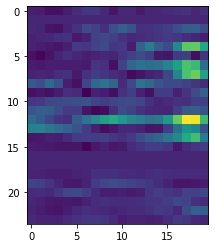

In [80]:
from matplotlib import pyplot as plt
plt.imshow(ds[233].reshape(24, 20))

In [77]:
%pdb on
ds = LandmarkWaveletDataset(landmark_files[2])

Automatic pdb calling has been turned ON


In [83]:
ds.data.astype(np.float32)

array([[ 56.73283  ,  55.33235  ,  57.212032 , ...,  14.019725 ,
          6.2734756,   8.784088 ],
       [ 49.570385 ,  54.952763 ,  50.57351  , ...,  13.934323 ,
          5.9965734,   8.918822 ],
       [ 33.072838 ,  44.528946 ,  38.30802  , ...,  13.859846 ,
          5.81308  ,   9.138367 ],
       ...,
       [ 46.726273 ,  46.911415 ,  92.50466  , ..., 202.38249  ,
        218.0907   , 234.4417   ],
       [ 91.68607  ,  85.13719  , 128.91125  , ..., 203.52051  ,
        218.91685  , 235.12961  ],
       [137.63997  , 126.59838  , 154.57462  , ..., 204.24069  ,
        219.40353  , 235.54301  ]], dtype=float32)

In [2]:
data_path = Path('/home/orel/Data/K6/2020-03-30/Down/')
landmarks_file = data_path / '0014DeepCut_resnet50_DownMay7shuffle1_1030000.h5'

In [7]:
import os
import re

# root directory of data
data_root = Path("/home/orel/Storage/Data/K6/")
landmark_files = []
for subdir in os.listdir(data_root):
    for file in os.listdir(data_root/subdir/'Down'):
        if re.match(r"00\d*DeepCut_resnet50_Down2May25shuffle1_1030000\.h5", file):
            lfile = data_root/subdir/'Down'/file
            landmark_files.append(lfile)

In [3]:
def extract_coords(landmarks_file):
    df = read_df(landmarks_file)
    return pd.unique([col[0] for col in df.columns])


extract_coords(landmarks_file)

array(['nose', 'neck', 'forepawR', 'forePawL', 'chest', 'belly',
       'hindpawR', 'hindpawL', 'tailbase', 'tail1', 'tail2', 'tail3'],
      dtype=object)

In [10]:
extract_coords(landmark_files[2])

array(['nose', 'neck', 'forepawR', 'forePawL', 'chest', 'belly',
       'hindpawR', 'hindpawL', 'tailbase', 'tail1', 'tail2', 'tail3'],
      dtype=object)